# XGBoost

In [35]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
import random as rd
from scipy.stats import uniform, truncnorm, randint
from sklearn.pipeline import Pipeline
import time
from matplotlib import pyplot
from xgboost import plot_importance
from scipy.stats import uniform, truncnorm, randint
from sklearn.model_selection import TimeSeriesSplit
import math
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import r2_score
# from sklearn.externals import joblib
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.preprocessing import StandardScaler    

In [19]:
df_final = pd.read_csv('data_with_top10_rating&votes.csv')

In [20]:
df_final.head(5)

,Unnamed: 0,Country_code,Country,Total Library Size,No. of TV Shows,No. of Movies,Cost Per Month - Basic ($),Cost Per Month - Standard ($),Cost Per Month - Premium ($),Movie_aveRating,TV_aveRating,GDP,Population,Gini_Index,Happiness_Share,Life_Satisfaction,Broadband_subscriptions,Cellular_subscriptions,averageRating,numVotes
0,0,AR,Argentina,4760,3154,1606,3.74,6.30,9.26,6.752242,6.752242,3.892881e+11,45376763.0,42.3,87.207031,5.901,21.178002,121.170400,7.300000,73667.636364
1,1,AU,Australia,6114,4050,2064,7.84,12.12,16.39,6.868653,6.868653,1.327836e+12,25687041.0,34.3,93.989067,7.137,35.049375,107.663235,6.735294,51170.882353
2,2,AT,Austria,5640,3779,1861,9.03,14.67,20.32,6.758839,6.758839,4.332585e+11,8917205.0,30.2,88.242794,7.213,28.934986,118.607839,6.720000,56523.133333
3,3,BE,Belgium,4990,3374,1616,10.16,15.24,20.32,6.794554,6.794554,5.218613e+11,11555997.0,27.2,88.242794,6.839,40.848697,99.483201,7.146667,92616.133333
4,4,BO,Bolivia,4991,3155,1836,7.99,10.99,13.99,6.776089,6.776089,3.657276e+10,11673029.0,43.6,88.242794,5.559,7.983520,101.125004,7.227273,73955.272727


In [21]:
train = pd.read_csv('train.csv')
X_train = train[['Total Library Size', 'No. of TV Shows', 'No. of Movies', 'Movie_aveRating', 'TV_aveRating', 'GDP',\
                 'Population', 'Gini_Index', 'Happiness_Share', 'Life_Satisfaction', 'Broadband_subscriptions',\
                 'Cellular_subscriptions','averageRating','numVotes']]
y_train = train['Cost Per Month - Standard ($)']

In [22]:
test = pd.read_csv('test.csv')
X_test = test[['Total Library Size', 'No. of TV Shows', 'No. of Movies', 'Movie_aveRating', 'TV_aveRating', 'GDP',\
                 'Population', 'Gini_Index', 'Happiness_Share', 'Life_Satisfaction', 'Broadband_subscriptions',\
                 'Cellular_subscriptions','averageRating','numVotes']]
y_test = test['Cost Per Month - Standard ($)']

In [23]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.1],
           'n_estimators': [100, 500],
           'colsample_bytree': [0.1, 0.3, 1],
           'min_child_weight': [1, 5, 10]}
xgbr = xgb.XGBRegressor()
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_absolute_percentage_error', 
                   verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest MAPE: ", (-clf.best_score_))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100}
Lowest MAPE:  0.1477510751801384


In [41]:
 # for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

def model_fit_regressor(x_train,x_test,y_train,y_test):
    model = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100,
                             colsample_bytree=0.1,  min_child_weight=10,
                             objective ='reg:squarederror')
    scaler = StandardScaler()
    columns = x_train.columns
    indexs_train = x_train.index
    x_train = pd.DataFrame(scaler.fit_transform(x_train),index = indexs_train, columns = columns)
    indexs_test = x_test.index
    x_test = pd.DataFrame(scaler.transform(x_test),index = indexs_test, columns = columns)

    model.fit(x_train, y_train) 
   
    score = model.score(x_train, y_train)   
    print("Training score: ", score) 
     
    # - cross validataion 
    scores = cross_val_score(model, x_train, y_train, cv=5)
    print("Mean cross-validation score: %.2f" % scores.mean())
    
    kfold = KFold(n_splits=10, shuffle=True)
    kf_cv_scores = cross_val_score(model, x_train, y_train, cv=kfold )
    print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
     
    ypred = model.predict(x_test)
    mse = mean_squared_error(y_test, ypred)
    mae = mean_absolute_error(y_test, ypred)
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % (mse**(1/2.0)))
    print("MAE:%.2f" % mae)
    
    x_ax = range(len(y_test))
    plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
    #plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
    plt.legend()
    plt.show()
    
    plotModelResults(model, X_train=x_train, X_test=x_test,  y_train=y_train, y_test=y_test, plot_intervals=True, plot_anomalies=True)
    
    return model

In [44]:
def plotModelResults(model, X_train, X_test, y_train, y_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
 
    """
    prediction = model.predict(X_test)
 
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
 
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                             cv=tscv,
                             scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
 
        scale = 20
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
 
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
 
        if plot_anomalies:
            anomalies = np.array([np.NaN] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, "o", markersize=10, label="Anomalies")
 
    error = mean_absolute_percentage_error(y_test, prediction)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    plot_importance(model)

Training score:  0.8474778858590571
Mean cross-validation score: 0.47
K-fold CV average score: 0.40
MSE: 4.85
RMSE: 2.20
MAE:1.67


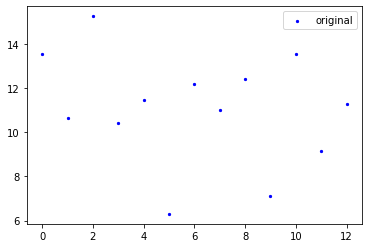

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

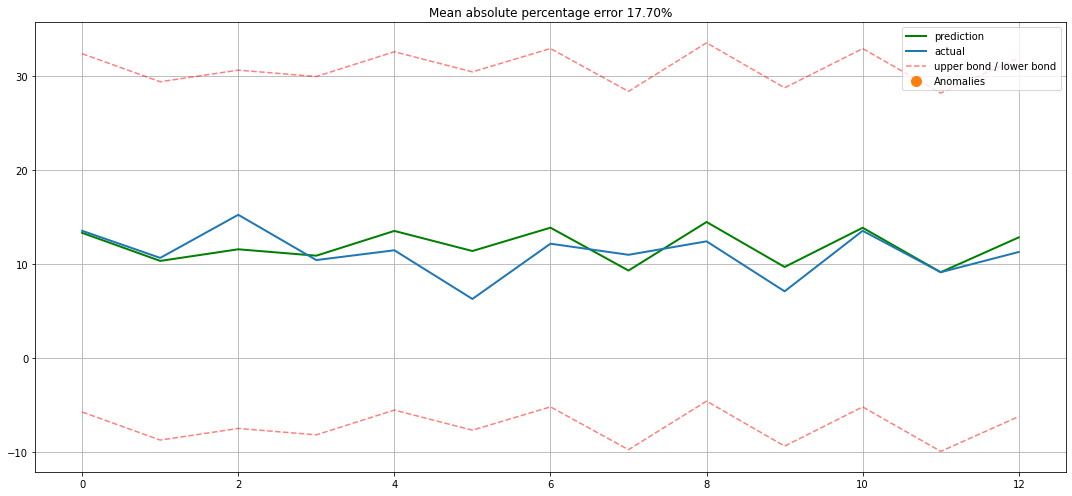

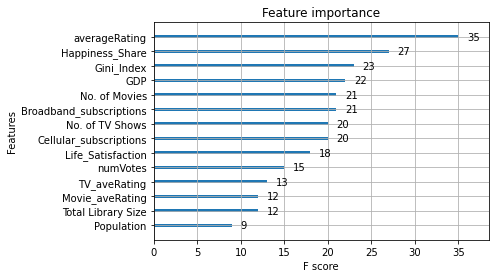

In [45]:
model_fit_regressor(X_train,X_test,y_train,y_test)